## $$\color{red}{\text{Nima Modirkiasaraee - 810102339}}$$
## $$\color{red}{\text{Question1: Genrealization}}$$


In [1]:
import torch
from torch import Tensor
from typing import Type
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import SVHN, MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, expansion: int = 1, downsample: nn.Module = None) -> None:
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, img_channels: int, block: Type[BasicBlock], num_classes: int = 1000) -> None:
        super(ResNet, self).__init__()
        layers = [2, 2, 2, 2]
        self.expansion = 1
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)

    def _make_layer(self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion),)
        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, self.expansion, downsample)
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, expansion=self.expansion))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [6]:
train_dataset = SVHN(root='svhn_data/', download=True, split = 'train', transform=ToTensor())
test_dataset = SVHN(root='svhn_data/', download=True, split = 'test', transform=ToTensor())
batch_size = 16
train_loader_svhn = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
test_loader_svhn = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)

Using downloaded and verified file: svhn_data/train_32x32.mat
Using downloaded and verified file: svhn_data/test_32x32.mat


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet(img_channels=3, block=BasicBlock, num_classes=10)
model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
def train(model, trainloader, optimizer, criterion, scheduler, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    scheduler.step()
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [7]:
epochs = 15
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()

### Training ###
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,train_loader_svhn,optimizer,criterion, scheduler, device)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 15
Training


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████▉| 4577/4579 [01:08<00:00, 76.22it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4579/4579 [01:09<00:00, 66.31it/s]

Training loss: 0.716, training acc: 77.149
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.59it/s]

Training loss: 0.373, training acc: 88.696
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.38it/s]

Training loss: 0.297, training acc: 91.045
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 71.15it/s]

Training loss: 0.246, training acc: 92.631
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.11it/s]

Training loss: 0.213, training acc: 93.594
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 71.00it/s]

Training loss: 0.183, training acc: 94.521
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 71.08it/s]

Training loss: 0.157, training acc: 95.191
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 71.43it/s]

Training loss: 0.134, training acc: 95.875
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.23it/s]

Training loss: 0.114, training acc: 96.507
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training



100%|██████████| 4579/4579 [01:06<00:00, 69.24it/s]

Training loss: 0.101, training acc: 96.826
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training



100%|██████████| 4579/4579 [01:08<00:00, 67.19it/s]

Training loss: 0.083, training acc: 97.308
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.37it/s]

Training loss: 0.075, training acc: 97.585
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.33it/s]

Training loss: 0.061, training acc: 97.988
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 69.66it/s]

Training loss: 0.052, training acc: 98.324
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.22it/s]

Training loss: 0.044, training acc: 98.598
--------------------------------------------------


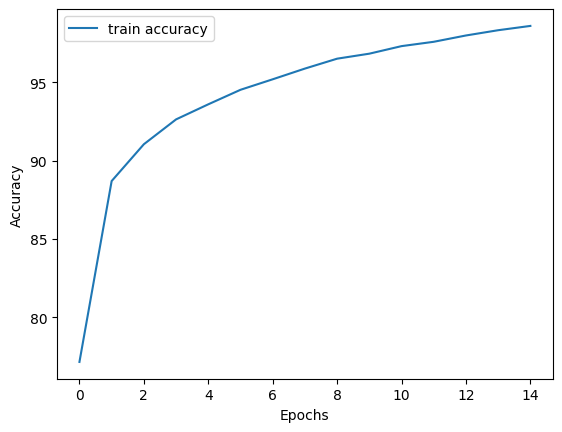

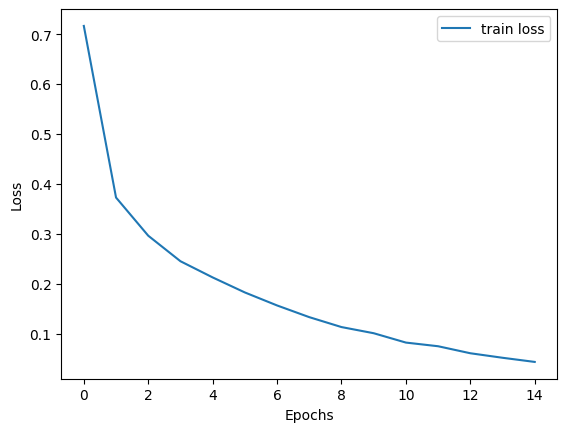

In [8]:
plt.plot(train_acc,label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_loss, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [9]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_svhn:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the SVHN test images: {accuracy}%')

Accuracy of the model on the SVHN test images: 92.57068223724647%


In [10]:
class GrayscaleToRgb:
    def __call__(self, img):
        return img.convert('RGB')

# Prepare the MNIST Test Data with necessary transformations
transform = Compose([
    GrayscaleToRgb(),
    ToTensor(),
])

mnist_test = MNIST(root='mnist_data/', train=False, download=True, transform=transform)
test_loader_mnist = DataLoader(mnist_test, batch_size=16, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 77683150.18it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 86587343.69it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34303145.15it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21722381.72it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [11]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy}%')

Accuracy of the model on the MNIST test images: 55.38%


### Implementing Resnet-18 network from scratch without batch normalization

In [12]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, expansion: int = 1, downsample: nn.Module = None) -> None:
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=3, padding=1, bias=False)

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, img_channels: int, block: Type[BasicBlock], num_classes: int = 1000) -> None:
        super(ResNet, self).__init__()
        layers = [2, 2, 2, 2]
        self.expansion = 1
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)

    def _make_layer(self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*self.expansion, kernel_size=1, stride=stride, bias=False))
        layers = [] # for storing the layers
        layers.append(
            block(self.in_channels, out_channels, stride, self.expansion, downsample)
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, expansion=self.expansion))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [13]:
model = ResNet(img_channels=3, block=BasicBlock, num_classes=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      )
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (relu)

In [14]:
epochs = 15
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()

### Training ###
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader_svhn, optimizer, criterion, scheduler, device)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 15
Training


100%|██████████| 4579/4579 [00:49<00:00, 91.80it/s]

Training loss: 2.242, training acc: 18.886
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training



100%|██████████| 4579/4579 [00:50<00:00, 90.96it/s]

Training loss: 2.200, training acc: 20.195
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training



100%|██████████| 4579/4579 [00:50<00:00, 89.83it/s]


Training loss: 1.428, training acc: 50.910
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training


100%|██████████| 4579/4579 [00:52<00:00, 88.00it/s]

Training loss: 0.721, training acc: 78.155
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training



100%|██████████| 4579/4579 [00:52<00:00, 87.64it/s]

Training loss: 0.525, training acc: 84.348
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training



100%|██████████| 4579/4579 [00:51<00:00, 88.83it/s]

Training loss: 0.441, training acc: 87.073
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training



100%|██████████| 4579/4579 [00:51<00:00, 89.24it/s]

Training loss: 0.387, training acc: 88.656
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training



100%|██████████| 4579/4579 [00:50<00:00, 89.83it/s]

Training loss: 0.348, training acc: 89.916
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training



100%|██████████| 4579/4579 [00:51<00:00, 89.03it/s]

Training loss: 0.317, training acc: 90.798
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training



100%|██████████| 4579/4579 [00:51<00:00, 89.23it/s]

Training loss: 0.291, training acc: 91.594
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training



100%|██████████| 4579/4579 [00:50<00:00, 90.67it/s]

Training loss: 0.269, training acc: 92.163
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training



100%|██████████| 4579/4579 [00:50<00:00, 90.74it/s]

Training loss: 0.248, training acc: 92.858
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training



100%|██████████| 4579/4579 [00:50<00:00, 89.96it/s]

Training loss: 0.229, training acc: 93.349
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training



100%|██████████| 4579/4579 [00:50<00:00, 90.12it/s]

Training loss: 0.214, training acc: 93.919
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training



100%|██████████| 4579/4579 [00:50<00:00, 90.40it/s]

Training loss: 0.197, training acc: 94.310
--------------------------------------------------


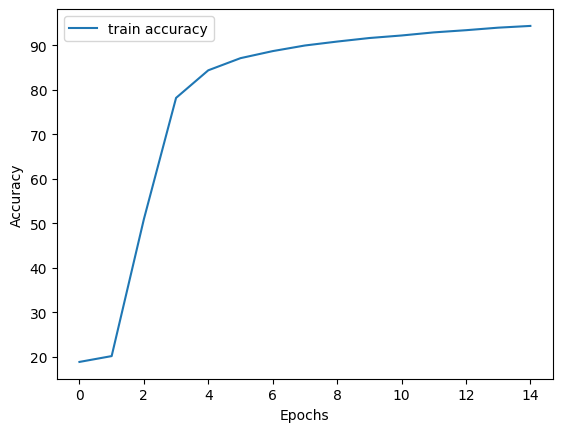

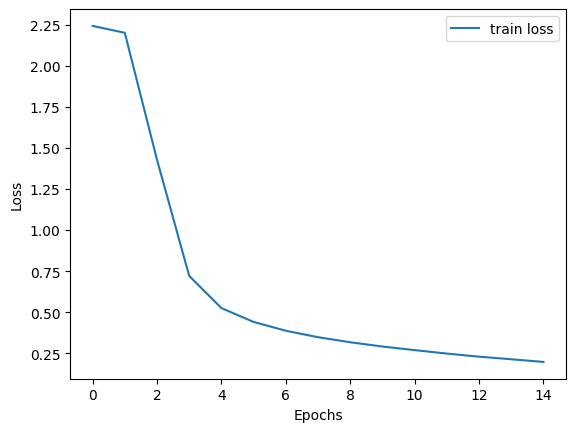

In [15]:
plt.plot(train_acc,label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_loss, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [16]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_svhn:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the SVHN test images: {accuracy}%')

Accuracy of the model on the SVHN test images: 91.9099569760295%


In [17]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy}%')

Accuracy of the model on the MNIST test images: 49.34%


## Label Smoothing Cross Entropy

In [18]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, expansion: int = 1, downsample: nn.Module = None) -> None:
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, img_channels: int, block: Type[BasicBlock], num_classes: int = 1000) -> None:
        super(ResNet, self).__init__()
        layers = [2, 2, 2, 2]
        self.expansion = 1
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)

    def _make_layer(self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion),)
        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, self.expansion, downsample)
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, expansion=self.expansion))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet(img_channels=3, block=BasicBlock, num_classes=10)
model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_probs = F.log_softmax(input, dim=-1)
        n_classes = input.size(-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (n_classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))
    
epochs = 15
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion =LabelSmoothingCrossEntropy(smoothing = 0.25)

### Training ###
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,train_loader_svhn,optimizer,criterion, scheduler, device)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 15
Training


100%|██████████| 4579/4579 [01:05<00:00, 70.10it/s]

Training loss: 1.464, training acc: 75.265
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.71it/s]

Training loss: 1.230, training acc: 88.983
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.14it/s]

Training loss: 1.188, training acc: 91.448
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.66it/s]

Training loss: 1.161, training acc: 92.926
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.02it/s]

Training loss: 1.142, training acc: 93.932
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.82it/s]

Training loss: 1.126, training acc: 94.912
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.62it/s]

Training loss: 1.111, training acc: 95.761
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training



100%|██████████| 4579/4579 [01:06<00:00, 68.64it/s]

Training loss: 1.100, training acc: 96.415
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.69it/s]

Training loss: 1.090, training acc: 96.912
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.69it/s]

Training loss: 1.082, training acc: 97.365
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 70.09it/s]

Training loss: 1.075, training acc: 97.716
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.61it/s]

Training loss: 1.070, training acc: 97.995
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training



100%|██████████| 4579/4579 [01:04<00:00, 70.59it/s]

Training loss: 1.063, training acc: 98.332
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 69.42it/s]

Training loss: 1.059, training acc: 98.569
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training



100%|██████████| 4579/4579 [01:05<00:00, 69.86it/s]

Training loss: 1.055, training acc: 98.801
--------------------------------------------------


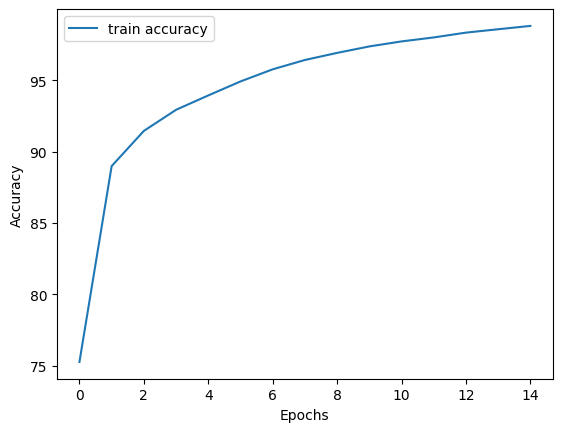

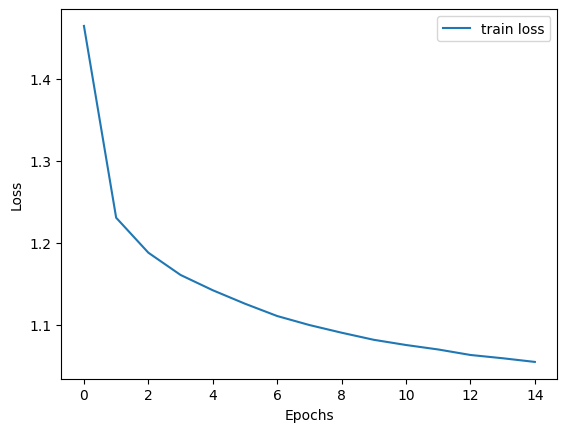

In [21]:
plt.plot(train_acc,label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_loss, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [22]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_svhn:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the SVHN test images: {accuracy}%')

Accuracy of the model on the SVHN test images: 92.95482483097726%


In [23]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy}%')

Accuracy of the model on the MNIST test images: 61.06%


## Data Augmentation

In [24]:
transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Rotation, Translation, Scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness and Contrast Adjustments
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective Transformation
    transforms.RandomCrop(size=(32, 32), padding=4),  # Cropping
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
])

train_dataset = SVHN(root='svhn_data/', split='train', download=True, transform=transform)
train_loader_svhn_augmentated = DataLoader(train_dataset, batch_size=16, shuffle=True)

Using downloaded and verified file: svhn_data/train_32x32.mat


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet(img_channels=3, block=BasicBlock, num_classes=10)
model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
epochs = 15
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()

### Training ###
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,train_loader_svhn_augmentated,optimizer,criterion, scheduler, device)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 15
Training


100%|██████████| 4579/4579 [01:57<00:00, 38.89it/s]


Training loss: 1.441, training acc: 51.588
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training


100%|██████████| 4579/4579 [01:56<00:00, 39.15it/s]


Training loss: 0.725, training acc: 77.082
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training


100%|██████████| 4579/4579 [02:02<00:00, 37.46it/s]


Training loss: 0.585, training acc: 81.774
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training


100%|██████████| 4579/4579 [02:01<00:00, 37.75it/s]


Training loss: 0.520, training acc: 83.779
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training


100%|██████████| 4579/4579 [02:03<00:00, 37.07it/s]


Training loss: 0.477, training acc: 85.231
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training


100%|██████████| 4579/4579 [02:03<00:00, 37.10it/s]


Training loss: 0.441, training acc: 86.404
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training


100%|██████████| 4579/4579 [02:02<00:00, 37.32it/s]


Training loss: 0.419, training acc: 87.162
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training


100%|██████████| 4579/4579 [02:04<00:00, 36.64it/s]


Training loss: 0.400, training acc: 87.598
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training


100%|██████████| 4579/4579 [02:04<00:00, 36.83it/s]


Training loss: 0.383, training acc: 88.179
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training


100%|██████████| 4579/4579 [02:00<00:00, 37.86it/s]


Training loss: 0.370, training acc: 88.633
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training


100%|██████████| 4579/4579 [01:58<00:00, 38.54it/s]


Training loss: 0.360, training acc: 88.970
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training


100%|██████████| 4579/4579 [01:59<00:00, 38.30it/s]


Training loss: 0.350, training acc: 89.280
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training


100%|██████████| 4579/4579 [01:59<00:00, 38.47it/s]


Training loss: 0.342, training acc: 89.441
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training


100%|██████████| 4579/4579 [01:58<00:00, 38.65it/s]


Training loss: 0.331, training acc: 89.914
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training


100%|██████████| 4579/4579 [01:58<00:00, 38.57it/s]

Training loss: 0.328, training acc: 89.970
--------------------------------------------------


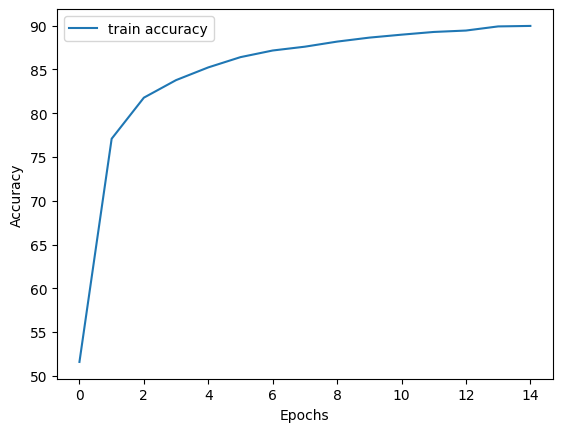

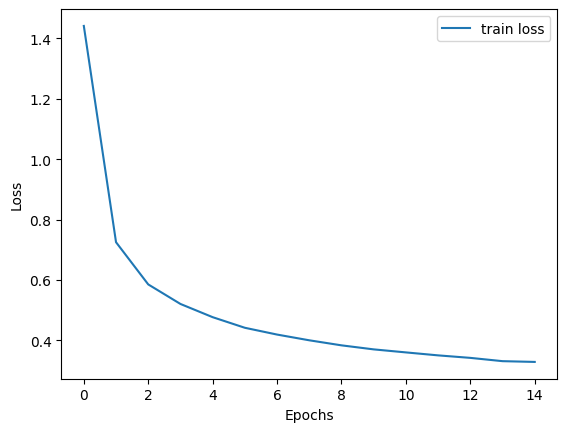

In [27]:
plt.plot(train_acc,label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_loss, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [28]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_svhn:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the SVHN test images: {accuracy}%')

Accuracy of the model on the SVHN test images: 94.08036263060848%


In [29]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy}%')

Accuracy of the model on the MNIST test images: 57.11%


## Train with pretrained ResNet-18

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet18(pretrained = True)
# Modify the last layer of the model
num_classes = 10
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
epochs = 15
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()

### Training ###
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,train_loader_svhn,optimizer,criterion, scheduler, device)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 15
Training


100%|██████████| 4579/4579 [00:58<00:00, 78.19it/s]


Training loss: 0.667, training acc: 79.033
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training


100%|██████████| 4579/4579 [00:58<00:00, 77.65it/s]


Training loss: 0.343, training acc: 89.862
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.29it/s]


Training loss: 0.274, training acc: 92.073
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.77it/s]


Training loss: 0.227, training acc: 93.349
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training


100%|██████████| 4579/4579 [00:58<00:00, 78.57it/s]


Training loss: 0.197, training acc: 94.286
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.22it/s]


Training loss: 0.171, training acc: 95.034
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.53it/s]


Training loss: 0.152, training acc: 95.519
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.23it/s]


Training loss: 0.137, training acc: 96.039
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.35it/s]


Training loss: 0.119, training acc: 96.470
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training


100%|██████████| 4579/4579 [01:00<00:00, 76.06it/s]


Training loss: 0.108, training acc: 96.774
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training


100%|██████████| 4579/4579 [01:02<00:00, 73.38it/s]


Training loss: 0.098, training acc: 97.103
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.53it/s]


Training loss: 0.081, training acc: 97.629
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training


100%|██████████| 4579/4579 [00:58<00:00, 78.56it/s]


Training loss: 0.072, training acc: 97.786
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.94it/s]


Training loss: 0.064, training acc: 97.948
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training


100%|██████████| 4579/4579 [00:57<00:00, 79.90it/s]

Training loss: 0.062, training acc: 98.089
--------------------------------------------------


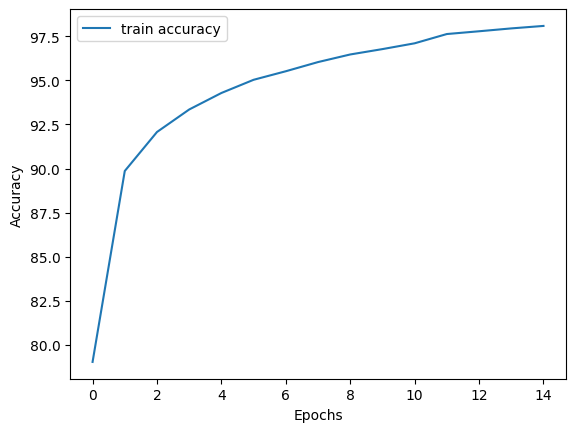

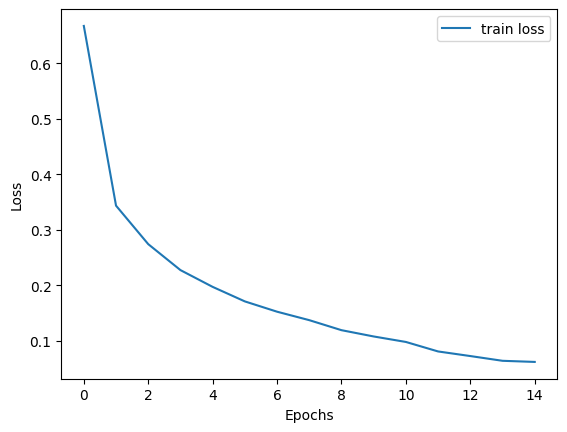

In [ ]:
plt.plot(train_acc,label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_loss, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_svhn:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the SVHN test images: {accuracy}%')

Accuracy of the model on the SVHN test images: 92.70897357098956%


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy}%')

Accuracy of the model on the MNIST test images: 61.3%


## Train the model with Adam optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet(img_channels=3, block=BasicBlock, num_classes=10)
model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
epochs = 15
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()

### Training ###
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,train_loader_svhn,optimizer,criterion, scheduler, device)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 15
Training


100%|██████████| 4579/4579 [01:05<00:00, 69.52it/s]


Training loss: 0.870, training acc: 72.218
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training


100%|██████████| 4579/4579 [01:05<00:00, 69.95it/s]


Training loss: 0.431, training acc: 87.112
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training


100%|██████████| 4579/4579 [01:05<00:00, 69.63it/s]


Training loss: 0.343, training acc: 89.874
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training


100%|██████████| 4579/4579 [01:04<00:00, 71.11it/s]


Training loss: 0.289, training acc: 91.437
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training


100%|██████████| 4579/4579 [01:03<00:00, 72.11it/s]


Training loss: 0.251, training acc: 92.633
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training


100%|██████████| 4579/4579 [01:03<00:00, 72.09it/s]


Training loss: 0.221, training acc: 93.516
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training


100%|██████████| 4579/4579 [01:04<00:00, 70.97it/s]


Training loss: 0.192, training acc: 94.392
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training


100%|██████████| 4579/4579 [01:03<00:00, 72.04it/s]


Training loss: 0.166, training acc: 95.138
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training


100%|██████████| 4579/4579 [01:03<00:00, 71.89it/s]


Training loss: 0.144, training acc: 95.865
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training


100%|██████████| 4579/4579 [01:04<00:00, 70.93it/s]


Training loss: 0.125, training acc: 96.258
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training


100%|██████████| 4579/4579 [01:03<00:00, 72.02it/s]


Training loss: 0.110, training acc: 96.762
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training


100%|██████████| 4579/4579 [01:03<00:00, 72.13it/s]


Training loss: 0.093, training acc: 97.233
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training


100%|██████████| 4579/4579 [01:04<00:00, 71.52it/s]


Training loss: 0.080, training acc: 97.592
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training


100%|██████████| 4579/4579 [01:03<00:00, 71.59it/s]


Training loss: 0.071, training acc: 97.806
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training


100%|██████████| 4579/4579 [01:03<00:00, 72.13it/s]

Training loss: 0.062, training acc: 98.078
--------------------------------------------------


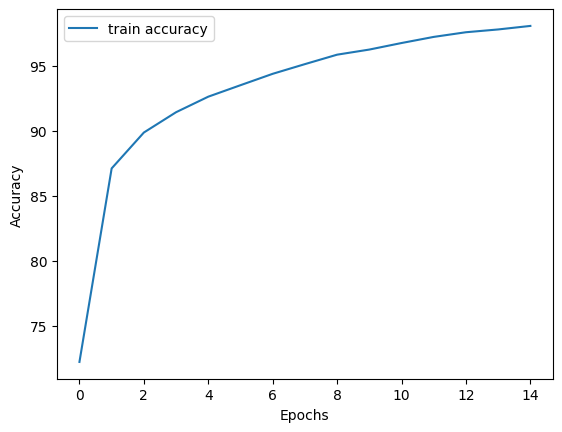

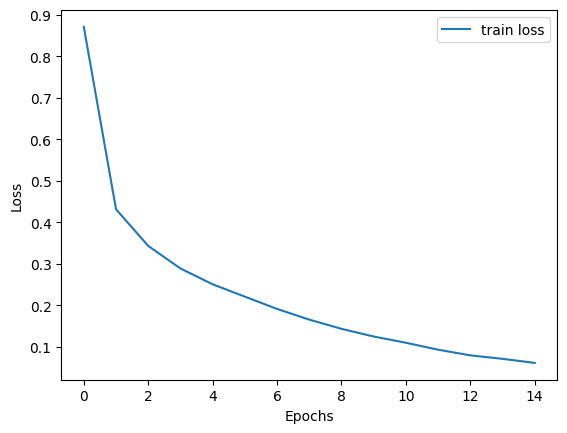

In [ ]:
plt.plot(train_acc,label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_loss, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_svhn:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the SVHN test images: {accuracy}%')

Accuracy of the model on the SVHN test images: 92.44775660725261%


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy}%')

Accuracy of the model on the MNIST test images: 64.96%


## Inverse model training - unsupervised

In [ ]:
class GrayscaleToRgb:
    def __call__(self, img):
        return img.convert('RGB')

transform = Compose([
    GrayscaleToRgb(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Rotation, Translation, Scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness and Contrast Adjustments
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective Transformation
    transforms.RandomCrop(size=(32, 32), padding=4),  # Cropping
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
])

trainset = MNIST(root='mnist_data/', train=True, download=True, transform=transform)
train_loader_mnist = DataLoader(trainset, batch_size=16, shuffle=True)

testset_mnist = MNIST(root='mnist_data/', train=False, download=True, transform=transform)
test_loader_mnist = DataLoader(testset_mnist, batch_size=16, shuffle=False)

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10) # Adjusting for 10 classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.1MB/s]


In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_probs = F.log_softmax(input, dim=-1)
        n_classes = input.size(-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (n_classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))
    
epochs = 15
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = LabelSmoothingCrossEntropy(smoothing = 0.25)

### Training ###
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,train_loader_mnist,optimizer,criterion, scheduler, device)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 15
Training


100%|██████████| 3750/3750 [01:50<00:00, 34.07it/s]


Training loss: 1.209, training acc: 91.767
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training


100%|██████████| 3750/3750 [01:54<00:00, 32.82it/s]


Training loss: 1.108, training acc: 96.592
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training


100%|██████████| 3750/3750 [01:44<00:00, 35.81it/s]


Training loss: 1.085, training acc: 97.445
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training


100%|██████████| 3750/3750 [01:44<00:00, 36.02it/s]


Training loss: 1.074, training acc: 97.833
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training


100%|██████████| 3750/3750 [01:40<00:00, 37.27it/s]


Training loss: 1.068, training acc: 98.033
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training


100%|██████████| 3750/3750 [01:41<00:00, 36.88it/s]


Training loss: 1.063, training acc: 98.297
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training


100%|██████████| 3750/3750 [01:41<00:00, 37.01it/s]


Training loss: 1.060, training acc: 98.402
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training


100%|██████████| 3750/3750 [01:39<00:00, 37.73it/s]


Training loss: 1.056, training acc: 98.605
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training


100%|██████████| 3750/3750 [01:40<00:00, 37.26it/s]


Training loss: 1.055, training acc: 98.602
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training


100%|██████████| 3750/3750 [01:40<00:00, 37.32it/s]


Training loss: 1.053, training acc: 98.775
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training


100%|██████████| 3750/3750 [01:39<00:00, 37.58it/s]


Training loss: 1.051, training acc: 98.840
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training


100%|██████████| 3750/3750 [01:38<00:00, 38.26it/s]


Training loss: 1.051, training acc: 98.778
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training


100%|██████████| 3750/3750 [01:39<00:00, 37.54it/s]


Training loss: 1.049, training acc: 98.938
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training


100%|██████████| 3750/3750 [01:42<00:00, 36.76it/s]


Training loss: 1.049, training acc: 98.937
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training


100%|██████████| 3750/3750 [01:41<00:00, 37.11it/s]

Training loss: 1.047, training acc: 98.987
--------------------------------------------------


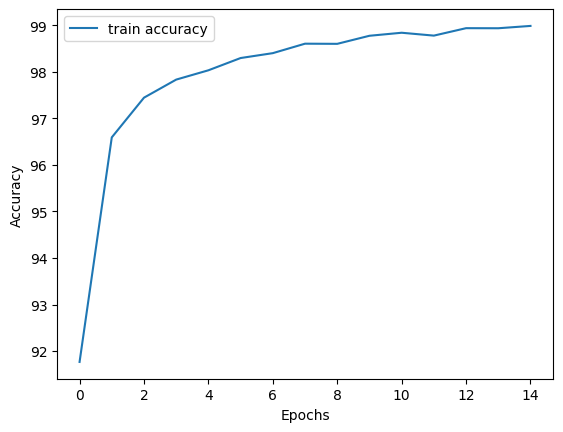

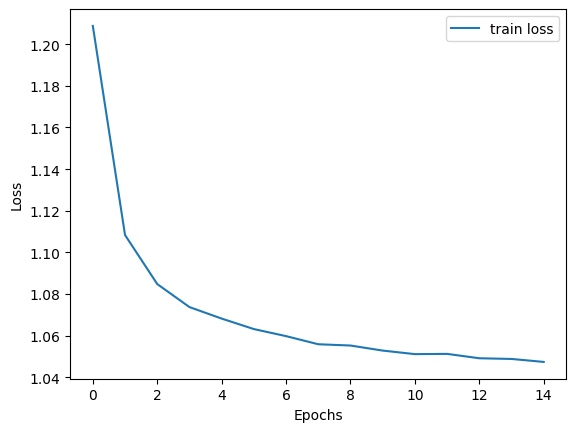

In [ ]:
plt.plot(train_acc,label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_loss, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy}%')

Accuracy of the model on the MNIST test images: 99.16%


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_svhn:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the SVHN test images: {accuracy}%')

Accuracy of the model on the SVHN test images: 23.14843269821758%


## Inverse model training - supervised

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10) # Adjusting for 10 classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_probs = F.log_softmax(input, dim=-1)
        n_classes = input.size(-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (n_classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))
    
epochs = 15
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = LabelSmoothingCrossEntropy(smoothing = 0.25)

### Training ###
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,train_loader_mnist,optimizer,criterion, scheduler, device)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 15
Training


100%|██████████| 3750/3750 [01:35<00:00, 39.45it/s]


Training loss: 1.182, training acc: 93.078
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 39.94it/s]


Training loss: 1.098, training acc: 97.008
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training


100%|██████████| 3750/3750 [01:34<00:00, 39.82it/s]


Training loss: 1.079, training acc: 97.763
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training


100%|██████████| 3750/3750 [01:34<00:00, 39.86it/s]


Training loss: 1.071, training acc: 97.998
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 39.98it/s]


Training loss: 1.064, training acc: 98.245
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 40.07it/s]


Training loss: 1.060, training acc: 98.413
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 40.19it/s]


Training loss: 1.056, training acc: 98.577
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 40.05it/s]


Training loss: 1.056, training acc: 98.680
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 40.06it/s]


Training loss: 1.052, training acc: 98.807
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 40.21it/s]


Training loss: 1.052, training acc: 98.758
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 39.94it/s]


Training loss: 1.050, training acc: 98.885
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 40.14it/s]


Training loss: 1.049, training acc: 98.917
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 40.13it/s]


Training loss: 1.049, training acc: 98.910
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training


100%|██████████| 3750/3750 [01:33<00:00, 40.14it/s]


Training loss: 1.047, training acc: 99.033
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training


100%|██████████| 3750/3750 [01:38<00:00, 38.12it/s]

Training loss: 1.047, training acc: 99.020
--------------------------------------------------


In [ ]:
svhn_dataset = SVHN(root='svhn_data/', split='train', download=True, transform=ToTensor())
ft_dataset, _ = random_split(svhn_dataset, [800, len(svhn_dataset)-800])
ft_loader = DataLoader(ft_dataset, batch_size=16, shuffle=True)

Using downloaded and verified file: svhn_data/train_32x32.mat


In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_probs = F.log_softmax(input, dim=-1)
        n_classes = input.size(-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (n_classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))
    
# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layers
for param in model.fc.parameters():
    param.requires_grad = True

epochs = 10
learning_rate = 0.001
optimizer = optim.Adam(model.fc.parameters(), lr = learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = LabelSmoothingCrossEntropy(smoothing = 0.25)

### Training ###
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,ft_loader,optimizer,criterion, scheduler, device)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 106.03it/s]


Training loss: 2.497, training acc: 21.875
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 119.35it/s]


Training loss: 2.372, training acc: 23.125
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 116.65it/s]


Training loss: 2.300, training acc: 23.750
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 121.63it/s]


Training loss: 2.262, training acc: 23.375
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 117.11it/s]


Training loss: 2.236, training acc: 23.875
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 119.47it/s]


Training loss: 2.215, training acc: 23.125
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 107.91it/s]


Training loss: 2.213, training acc: 23.750
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 104.19it/s]


Training loss: 2.168, training acc: 26.000
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 123.84it/s]


Training loss: 2.176, training acc: 27.000
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


100%|██████████| 50/50 [00:00<00:00, 118.28it/s]

Training loss: 2.164, training acc: 26.875
--------------------------------------------------


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the MNIST test images: {accuracy}%')

Accuracy of the model on the MNIST test images: 74.58%


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_svhn:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the SVHN test images: {accuracy}%')

Accuracy of the model on the SVHN test images: 28.196066379840197%
